In [1]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from IPython.display import display
rcParams.update({'figure.autolayout': True})
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import sys
import collections
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
import ipywidgets as widgets
from ipywidgets import interact, fixed
from Bio.Data.IUPACData import ambiguous_dna_values
plt.tight_layout()


Read in data that was generated by galaxy team and EC-19 team along with the table from Ryan that has the metadata.

In [2]:
srr_mdata = pd.read_csv("https://raw.githubusercontent.com/elais/ACTIV-TRACE-analysis/main/data/ONT_Illumina_TRACE_test_set.csv", skipinitialspace=True)
galaxy_df = pd.read_csv("https://raw.githubusercontent.com/elais/ACTIV-TRACE-analysis/main/data/galaxy.csv",  skipinitialspace=True, sep=",")
galaxy_df['Accession'] = galaxy_df['Accession'].str.strip()
ec19_df = pd.read_csv("https://raw.githubusercontent.com/elais/ACTIV-TRACE-analysis/main/data/ONT_illumina_TRACE_test_result_with_metadata.txt", skipinitialspace=True, sep="\t")
ec19_df['Accession'] = ec19_df['Accession'].str.strip()
galaxy_df[galaxy_df['Accession'] == "ERR4969142"]

,Group_Name,Accession,Pos,Ref,Alt,DP,G_AD_2,Alt_Freq


In [3]:
def galaxy_status(row):
    if len(row['Ref']) > len(row['Alt']) :
        return "deletion"
    elif len(row['Ref']) < len(row['Alt']) :
        return "insertion"
    elif len(row['Ref']) == len(row['Alt']):
        if len(row['Ref']) == 1 and len(row['Alt']) == 1:
            if row['Ref'] != row['Alt']:
                return "snp"
        elif len(row['Ref']) > 1 and len(row['Alt']) > 1:
            return "multi-snp"
galaxy_df['gal_status'] = galaxy_df.apply(galaxy_status, axis=1)

#=================================================================
galaxy_multisnp = pd.DataFrame()
for x, row in galaxy_df[galaxy_df['gal_status']=="multi-snp"].iterrows():
    pos = row['Pos']
    mut_pos = 0
    for nuc in row['Ref']:
        galaxy_multisnp = galaxy_multisnp.append({'Group_Name':'Galaxy',
                        'Accession':row['Accession'],
                        "Pos":pos, "Ref":row['Ref'][mut_pos],
                        "Alt":row['Alt'][mut_pos], "DP":row['DP'],
                        "G_AD_2":row["G_AD_2"],	"Alt_Freq":row["Alt_Freq"], "gal_status":row["gal_status"]}, ignore_index=True)
        pos = pos + 1
        mut_pos = mut_pos + 1
#=================================================================
galaxy_del = pd.DataFrame()
for x, row in galaxy_df[galaxy_df['gal_status']=="deletion"].iterrows():
    pos = row['Pos']
    del_pos = 0
    if row["Ref"][0] == row["Alt"]:
        galaxy_del = galaxy_del.append({'Group_Name':'Galaxy',
                            'Accession':row['Accession'],
                            "Pos":pos+1, "Ref":row['Ref'][1:],
                            "Alt":'-', "DP":row['DP'],
                            "G_AD_2":row["G_AD_2"],	"Alt_Freq":row["Alt_Freq"], "gal_status":row["gal_status"]}, ignore_index=True)
    else:
        galaxy_del = galaxy_del.append({'Group_Name':'Galaxy',
                                'Accession':row['Accession'],
                                "Pos":pos, "Ref":row['Ref'][0],
                                "Alt":'-', "DP":row['DP'],
                                "G_AD_2":row["G_AD_2"],	"Alt_Freq":row["Alt_Freq"], "gal_status":"snp"}, ignore_index=True)
        galaxy_del = galaxy_del.append({'Group_Name':'Galaxy',
                                'Accession':row['Accession'],
                                "Pos":pos+1, "Ref":row['Ref'][1:],
                                "Alt":'-', "DP":row['DP'],
                                "G_AD_2":row["G_AD_2"],	"Alt_Freq":row["Alt_Freq"], "gal_status":row["gal_status"]}, ignore_index=True)
galaxy_df_v2 = pd.concat([galaxy_del, galaxy_multisnp, galaxy_df[~galaxy_df['gal_status'].isin(['deletion', 'multi-snp'])] ])
# plt.pie(galaxy_df_final['gal_status'].count())

In [4]:
def ec19_status(row):
    if len(row['Ref']) > len(row['Alt']):
        if row['Alt'] == "-":
            return "deletion"
        else:
            return None
    elif len(row['Ref']) < len(row['Alt']):
        if '(' in row['Alt']:
            iupac = row['Alt'].split('(')[1].replace(')', '')
            iupac_nt = ambiguous_dna_values[iupac]
            if row['Ref'] in iupac_nt:
                return "snv"
            else:
                return "snp"
        else:
            return "insertion"
    elif len(row['Ref']) == len(row['Alt']):
        if len(row['Ref']) == 1 and len(row['Alt']) == 1:
            if row['Alt'] == "-":
                return "deletion"
            elif row['Ref'] != row['Alt']:
                return "snp"
        elif len(row['Ref']) > 1 and len(row['Alt']) > 1:
            return "multi-snp"
        else:
            return None
    else:
        return None
                
    
    # elif len(row['Ref']) == 1 and len(row['Alt']) == 1:
ec19_df['ec19_status'] = ec19_df.apply(ec19_status, axis=1)
# ec19_df[ec19_df['ec19_status'] == "deletion"][['Group_Name',	'Accession',	'Pos',	'Ref',	'Alt', 'DP', "G_AD_2",	"Alt_Freq", "ec19_status", "platform"]]
# ec19_df

In [5]:
galaxy_df_v2['galaxy_vars'] = galaxy_df_v2['Accession'].astype(str) + "_" + galaxy_df_v2['Pos'].astype(str)
ec19_df['ec19_vars'] = ec19_df['Accession'].astype(str) + "_" + ec19_df['Pos'].astype(str) + ".0"
def expand_amb(row):
    if '(' in row['Alt']:
        iupac = row['Alt'].split('(')[1].replace(')', '')
        return ambiguous_dna_values[iupac]
    else:
        return row['Alt']
ec19_df['New_Alt'] = ec19_df.apply(expand_amb, axis=1)
ec19_df

,Group_Name,Accession,Pos,Ref,Alt,DP,G_AD_2,Alt_Freq,biosample,platform,bioproject,center_name,librarylayout,libraryselection,librarysource,attributes,ec-19_run_with_primer_trim,ec19_status,ec19_vars,New_Alt
0,LANL,ERR4364963,241,C,T,3510,3441,0.9806,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_241.0,T
1,LANL,ERR4364963,3037,C,T,1752,1750,0.9994,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_3037.0,T
2,LANL,ERR4364963,4186,T,C,6464,6462,0.9998,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_4186.0,C
3,LANL,ERR4364963,11801,G,A,6513,6511,0.9997,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_11801.0,A
4,LANL,ERR4364963,14408,C,T,6418,6414,0.9995,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_14408.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,LANL,SRR13870639,23874,C,C(Y),1968,515,0.2617,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snv,SRR13870639_23874.0,CT
8244,LANL,SRR13870639,25563,G,T,7268,6600,0.9081,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snp,SRR13870639_25563.0,T
8245,LANL,SRR13870639,27357,A,G,7847,6633,0.8453,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snp,SRR13870639_27357.0,G
8246,LANL,SRR13870639,27964,C,T,4417,4008,0.9076,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snp,SRR13870639_27964.0,T


In [6]:
galaxy_acc_list = [acc.strip() for acc in list(set(galaxy_df_v2['Accession'].to_list()))]
ec19_acc_list = [acc.strip() for acc in list(set(ec19_df['Accession'].to_list()))]
galaxy_df_final = galaxy_df_v2[galaxy_df_v2['Accession'].isin(ec19_acc_list)]
ec19_df_final = ec19_df[ec19_df['Accession'].isin(galaxy_acc_list)]
ec19_df_final
# ec19_df_final[ec19_df_final['Accession'] == "ERR5629600"]
# "ERR4969142" in ec19_acc_list
# "A" in ["A", "B"]
# ec19_acc_list
# list(set(galaxy_df_final['Accession'].to_list()))

,Group_Name,Accession,Pos,Ref,Alt,DP,G_AD_2,Alt_Freq,biosample,platform,bioproject,center_name,librarylayout,libraryselection,librarysource,attributes,ec-19_run_with_primer_trim,ec19_status,ec19_vars,New_Alt
0,LANL,ERR4364963,241,C,T,3510,3441,0.9806,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_241.0,T
1,LANL,ERR4364963,3037,C,T,1752,1750,0.9994,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_3037.0,T
2,LANL,ERR4364963,4186,T,C,6464,6462,0.9998,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_4186.0,C
3,LANL,ERR4364963,11801,G,A,6513,6511,0.9997,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_11801.0,A
4,LANL,ERR4364963,14408,C,T,6418,6414,0.9995,SAMEA7080096,ILLUMINA,PRJEB37886,ORIGINATING LAB: WALES SPECIALIST VIROLOGY CEN...,PAIRED,PCR,VIRAL RNA,ena_last_update_sam: 2020-07-22;sample_capture...,artic_primer_v3,snp,ERR4364963_14408.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,LANL,SRR13870639,23874,C,C(Y),1968,515,0.2617,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snv,SRR13870639_23874.0,CT
8244,LANL,SRR13870639,25563,G,T,7268,6600,0.9081,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snp,SRR13870639_25563.0,T
8245,LANL,SRR13870639,27357,A,G,7847,6633,0.8453,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snp,SRR13870639_27357.0,G
8246,LANL,SRR13870639,27964,C,T,4417,4008,0.9076,SAMN18188233,OXFORD_NANOPORE,PRJNA707211,UNIVERSITY OF TEXAS MEDICAL BRANCH,SINGLE,RT-PCR,VIRAL RNA,collection_date_sam: 2020-04;primary_search: 1...,NaN,snp,SRR13870639_27964.0,T


In [7]:
def disp_ec19srr(srr):
    display(ec19_df_final[ec19_df_final['Accession'] == srr][['Group_Name', 'Accession', 'Pos', 'Ref', 'Alt', 'DP', 'G_AD_2', 'Alt_Freq', 'ec19_status', 'platform', 'librarylayout', 'libraryselection', 'ec-19_run_with_primer_trim']])
interact(disp_ec19srr, srr=sorted(list(set(ec19_df['Accession'].to_list()))));

<Figure size 640x480 with 0 Axes>

interactive(children=(Dropdown(description='srr', options=('ERR4364963', 'ERR4365002', 'ERR4365125', 'ERR43651…

In [8]:
def disp_galaxysrr(srr):
    display(galaxy_df_final[galaxy_df_final['Accession'] == srr])
interact(disp_galaxysrr, srr=sorted(list(set(galaxy_df_final['Accession'].to_list()))));


interactive(children=(Dropdown(description='srr', options=('ERR4364963', 'ERR4365002', 'ERR4365125', 'ERR43651…

Add a column to galaxy dataframe for naming if its snp, in, del, or multi-snp

Expand deletion

Concatenating dataframes

Add the status to ec19 dataframe

Add a column that combines SRR and the position for each column.

Expand IUPAC code to nuleotides

In [9]:
def extract_acc(row):
#     print(row)
    if str(row['Accession_x']) == "nan":
        return {"Accession": row['Accession_y'], "Pos": row['ec19_vars'].split("_")[1]}
    elif str(row['Accession_y']) == "nan":
        return {"Accession": row['Accession_x'], "Pos": row['galaxy_vars'].split("_")[1]}
    else:
        if row['Accession_x'] == row['Accession_y']:
            return {"Accession":row['Accession_y'], "Pos": row['galaxy_vars'].split("_")[1]}
        else:
            print(row['Accession_x'])
            print(row['Accession_y'])            
            print("Error!")
            sys.exit()
    
gal_ec19_df = galaxy_df_final[['Accession', 'Ref','Alt', 'galaxy_vars', 'gal_status']].merge(ec19_df_final[['Accession','Ref','ec19_vars','New_Alt','ec19_status', 'platform']], left_on="galaxy_vars", right_on="ec19_vars", how="outer")
gal_ec19_df = gal_ec19_df.rename(columns = {"Ref_x":"galaxy_ref", "Ref_y":"ec19_ref", "Alt":"galaxy_alt", "New_Alt":"ec19_alt"} )
apply_df = gal_ec19_df.apply(extract_acc, result_type='expand', axis=1)
gal_ec19_df = pd.concat([gal_ec19_df, apply_df], axis='columns')
gal_ec19_df = gal_ec19_df.drop(['Accession_x', 'Accession_y'], axis=1)
gal_ec19_df


,galaxy_ref,galaxy_alt,galaxy_vars,gal_status,ec19_ref,ec19_vars,ec19_alt,ec19_status,platform,Accession,Pos
0,T,-,ERR4364963_27098.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4364963,27098.0
1,TA,-,ERR4365125_6776.0,deletion,TA,ERR4365125_6776.0,-,deletion,ILLUMINA,ERR4365125,6776.0
2,TG,-,ERR4365125_7910.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4365125,7910.0
3,G,-,ERR4365125_9251.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4365125,9251.0
4,GTG,-,ERR4365125_9267.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4365125,9267.0
...,...,...,...,...,...,...,...,...,...,...,...
7216,NaN,NaN,NaN,NaN,G,SRR13870639_2198.0,AG,snv,OXFORD_NANOPORE,SRR13870639,2198.0
7217,NaN,NaN,NaN,NaN,C,SRR13870639_5736.0,CT,snv,OXFORD_NANOPORE,SRR13870639,5736.0
7218,NaN,NaN,NaN,NaN,T,SRR13870639_11075.0,-,deletion,OXFORD_NANOPORE,SRR13870639,11075.0
7219,NaN,NaN,NaN,NaN,C,SRR13870639_23874.0,CT,snv,OXFORD_NANOPORE,SRR13870639,23874.0


In [10]:
def check_match(row):
    # print(row)
    if str(row['galaxy_alt']) in str(row['ec19_alt']):
        return "shared"
    elif pd.isna(row['galaxy_ref']): # SNP/indel in EC-19, not in galaxy
        return "EC19"
    elif pd.isna(row['ec19_ref']): #SNP/indel in galaxy, not in EC-19
        return "Galaxy"
    elif pd.isna(row['ec19_alt']): #
        # print(row)
        if row['galaxy_alt'] == "-":
            return "Galaxy"
    else:
        return "EC19-galaxy"
    
    
gal_ec19_df['match'] = gal_ec19_df.apply(check_match, axis=1)
# gal_ec19_df = gal_ec19_df.groupby(['platform']).fillna(method="ffill")
# gal_ec19_df[gal_ec19_df['match'] == False].to_csv("test.txt")
gal_ec19_df

,galaxy_ref,galaxy_alt,galaxy_vars,gal_status,ec19_ref,ec19_vars,ec19_alt,ec19_status,platform,Accession,Pos,match
0,T,-,ERR4364963_27098.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4364963,27098.0,Galaxy
1,TA,-,ERR4365125_6776.0,deletion,TA,ERR4365125_6776.0,-,deletion,ILLUMINA,ERR4365125,6776.0,shared
2,TG,-,ERR4365125_7910.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4365125,7910.0,Galaxy
3,G,-,ERR4365125_9251.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4365125,9251.0,Galaxy
4,GTG,-,ERR4365125_9267.0,deletion,NaN,NaN,NaN,NaN,NaN,ERR4365125,9267.0,Galaxy
...,...,...,...,...,...,...,...,...,...,...,...,...
7216,NaN,NaN,NaN,NaN,G,SRR13870639_2198.0,AG,snv,OXFORD_NANOPORE,SRR13870639,2198.0,EC19
7217,NaN,NaN,NaN,NaN,C,SRR13870639_5736.0,CT,snv,OXFORD_NANOPORE,SRR13870639,5736.0,EC19
7218,NaN,NaN,NaN,NaN,T,SRR13870639_11075.0,-,deletion,OXFORD_NANOPORE,SRR13870639,11075.0,EC19
7219,NaN,NaN,NaN,NaN,C,SRR13870639_23874.0,CT,snv,OXFORD_NANOPORE,SRR13870639,23874.0,EC19


In [11]:
gal_ec19_df['platform'] = gal_ec19_df.groupby('Accession', sort=False)['platform'].apply(lambda x: x.ffill().bfill())

In [12]:
def disp_comp(srr):
    display(gal_ec19_df[gal_ec19_df['Accession'] == srr])
interact(disp_comp, srr=sorted(list(set(gal_ec19_df['Accession'].to_list()))));

interactive(children=(Dropdown(description='srr', options=('ERR4364963', 'ERR4365002', 'ERR4365125', 'ERR43651…

In [13]:
def plot_comp(srr):
    sns.set_theme(style="whitegrid")
    srr_df = gal_ec19_df[gal_ec19_df['Accession'] == srr]
    ax=sns.barplot(data=srr_df.groupby('match').count()[['Pos']].transpose())
    ax.set_title('Shared and unique differences')
interact(plot_comp, srr=sorted(list(set(gal_ec19_df['Accession'].to_list()))));

interactive(children=(Dropdown(description='srr', options=('ERR4364963', 'ERR4365002', 'ERR4365125', 'ERR43651…

In [14]:
ONT_df = gal_ec19_df[gal_ec19_df['platform'] == "OXFORD_NANOPORE"]
ILL_df = gal_ec19_df[gal_ec19_df['platform'] == "ILLUMINA"]
ONT_df
ILL_df

,galaxy_ref,galaxy_alt,galaxy_vars,gal_status,ec19_ref,ec19_vars,ec19_alt,ec19_status,platform,Accession,Pos,match
0,T,-,ERR4364963_27098.0,deletion,NaN,NaN,NaN,NaN,ILLUMINA,ERR4364963,27098.0,Galaxy
1,TA,-,ERR4365125_6776.0,deletion,TA,ERR4365125_6776.0,-,deletion,ILLUMINA,ERR4365125,6776.0,shared
2,TG,-,ERR4365125_7910.0,deletion,NaN,NaN,NaN,NaN,ILLUMINA,ERR4365125,7910.0,Galaxy
3,G,-,ERR4365125_9251.0,deletion,NaN,NaN,NaN,NaN,ILLUMINA,ERR4365125,9251.0,Galaxy
4,GTG,-,ERR4365125_9267.0,deletion,NaN,NaN,NaN,NaN,ILLUMINA,ERR4365125,9267.0,Galaxy
...,...,...,...,...,...,...,...,...,...,...,...,...
7182,NaN,NaN,NaN,NaN,A,SRR13870673_11673.0,AG,snv,ILLUMINA,SRR13870673,11673.0,EC19
7183,NaN,NaN,NaN,NaN,C,SRR13870673_25324.0,AC,snv,ILLUMINA,SRR13870673,25324.0,EC19
7184,NaN,NaN,NaN,NaN,G,SRR13870681_8322.0,CG,snv,ILLUMINA,SRR13870681,8322.0,EC19
7185,NaN,NaN,NaN,NaN,G,SRR13870682_8322.0,CG,snv,ILLUMINA,SRR13870682,8322.0,EC19


In [15]:
ONT_df[ONT_df['match'].isna()]

,galaxy_ref,galaxy_alt,galaxy_vars,gal_status,ec19_ref,ec19_vars,ec19_alt,ec19_status,platform,Accession,Pos,match


In [16]:
def check_diff(row):
    match_lst = list(set(row['match'].to_list()))
    print(match_lst)
    if match_lst == ["shared"]:
        return "all-shared"
    elif sorted(match_lst) == sorted(["shared", "EC19"]):
        return "shared + EC19"
    elif sorted(match_lst) == sorted(["shared", "EC19-galaxy"]):
        return "shared + EC19-galaxy"
    elif sorted(match_lst) == sorted(["Galaxy", "EC19"]):
        return "galaxy + EC19"
    elif sorted(match_lst) == sorted(["shared", "Galaxy"]):
        return "shared + galaxy"
    elif sorted(match_lst) == sorted(["shared", "Galaxy", "EC19-galaxy"]):
        return "shared + galaxy + EC19-galaxy"
    elif sorted(match_lst) == sorted(["shared", "EC19", "Galaxy"]):
        return "shared + EC19 + galaxy"
    elif sorted(match_lst) == sorted(["shared", "EC19", "Galaxy", "EC19-galaxy"]):
        return "shared + EC19 + galaxy + EC19-galaxy"
    elif sorted(match_lst) == sorted(["shared", "EC19", "EC19-galaxy"]):
        return "shared + EC19 + EC19-galaxy"
    elif sorted(match_lst) == sorted(["Galaxy"]):
        return "Galaxy"
    elif sorted(match_lst) == sorted(["EC19"]):
        return "EC19"
    else:
        sys.exit()
    

# ONT_df.groupby(['Accession']).apply(check_diff)
ILL_diff_df = pd.DataFrame(ILL_df.groupby(['Accession']).apply(check_diff)).reset_index()
ILL_diff_df.columns = ["Accession", "diffs"]
ONT_diff_df = pd.DataFrame(ONT_df.groupby(['Accession']).apply(check_diff)).reset_index()
ONT_diff_df.columns = ["Accession", "diffs"]

# ILL_diff_df.groupby('diffs').count().reset_index()

['Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['shared']
['Galaxy', 'shared']
['Galaxy', 'shared']
['shared']
['shared']
['shared']
['shared']
['shared']
['shared']
['EC19', 'Galaxy', 'shared']
['shared']
['EC19', 'Galaxy', 'shared']
['Galaxy', 'shared']
['Galaxy', 'shared']
['Galaxy', 'shared']
['EC19', 'Galaxy']
['Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['shared']
['EC19', 'shared']
['shared']
['EC19', 'Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['shared']
['shared']
['Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['shared']
['EC19', 'Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['EC19-galaxy', 'Galaxy', 'shared']
['Galaxy', 'shared']
['Galaxy', 'shared']
['Galaxy', 'shared']
['EC19', 'Galaxy', 'shared']
['shared']
['Galaxy', 'shared']
['Galaxy', 'shared']
['shared']
['shared']
['shared']
['shared']
['share

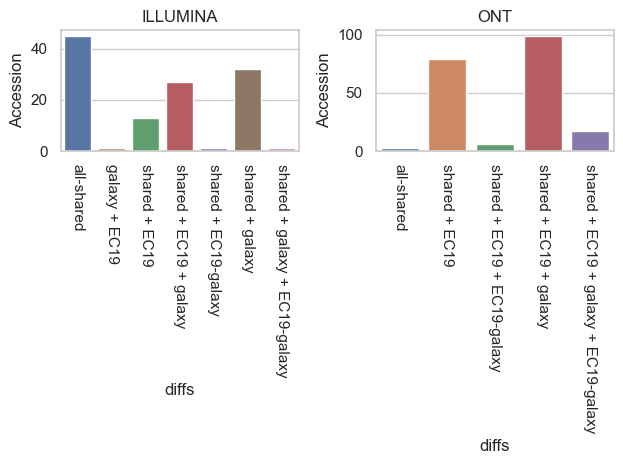

In [17]:
# plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.set_theme(style="whitegrid")
ax=sns.barplot(data=ILL_diff_df.groupby('diffs').count().reset_index(), x='diffs', y='Accession')
ax.tick_params(axis='x', rotation=270)
ax.set_title('ILLUMINA')
plt.subplot(1,2,2)
sns.set_theme(style="whitegrid")
ax=sns.barplot(data=ONT_diff_df.groupby('diffs').count().reset_index(), x='diffs', y='Accession')
ax.tick_params(axis='x', rotation=270)
ax.set_title('ONT')
plt.show()

In [20]:
GE_Ill_df = ILL_diff_df[ILL_diff_df['diffs'] == "galaxy + EC19"]
GE_Ill_acc = GE_Ill_df['Accession'].to_list()
gal_ec19_df[gal_ec19_df['Accession'] == "ERR4969177"]
# galaxy_df[galaxy_df['Accession'] == "ERR4969177"]

,Accession,diffs
17,ERR4969177,galaxy + EC19


In [19]:
def check_overlap(row):
    if collections.Counter(row['galaxy']) == collections.Counter(row['ec19']):
        return True
    else:
        return False

def find_unique(list1):
    gx_pos = row['galaxy'].to_list()
    ec19_pos = row['ec19'].to_list()
    gx_unq = np.setdiff1d(gx_pos,ec19_pos)
    ec19_unq = np.setdiff1d(ec19_pos, gx_pos)
    return gx_unq

def merge_gx_ec19(galaxy_df, ec19_df):
    ec19_gx_ont = pd.concat([galaxy_df[['Group_Name', 'Accession', 'Pos']], ec19_df[['Group_Name', 'Accession', 'Pos']]], ignore_index=True)
    gx_all_pos = galaxy_df.groupby(['Accession'])['Pos'].apply(list).reset_index()
    ec19_all_pos = ec19_df.groupby(['Accession'])['Pos'].apply(list).reset_index()
    sync_all_pos = ec19_all_pos.merge(gx_all_pos, on="Accession")
    sync_all_pos.columns = ["acc", "galaxy", "ec19"]
    return sync_all_pos

def compare_srrs(merged_df):
    merged_df['overlapped'] = merged_df.apply(check_overlap, axis=1)
    return merged_df.groupby('overlapped').agg('count').reset_index()

ont_comp_df = merge_gx_ec19(sync_ec19_ont, sync_galaxy_ont)
ill_comp_df= merge_gx_ec19(sync_ec19_ill, sync_galaxy_ill)
ill_comp_df
# compare_srrs(ont_comp_df)
# compare_srrs(ill_comp_df)
# ont_comp_df['galaxy_unq'] = ont_comp_df.apply(lambda row: np.setdiff1d(row["galaxy"], row["ec19"]), axis=1)
# ont_comp_df['ec19_unq'] = ont_comp_df.apply(lambda row: np.setdiff1d(row["ec19"], row["galaxy"]), axis=1)
# ill_comd_df

NameError: name 'sync_ec19_ont' is not defined

In [ ]:
sync_ec19_ill['Alt'].to_list()

In [ ]:
ill_comd_df

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
venn2_unweighted([set(sync_galaxy_ill['galaxy_vars'].to_list()), set(sync_ec19_ill['ec19_vars'].to_list())], set_labels = ('galaxy', 'EC-19'), alpha = 0.5)
plt.title("OXFORD NANOPORE")
plt.subplot(1, 2, 2)
venn2_unweighted([set(sync_galaxy_ont['galaxy_vars'].to_list()), set(sync_ec19_ont['ec19_vars'].to_list())], set_labels = ('galaxy', 'EC-19'), alpha = 0.5)
plt.title("ILLUMINA")
plt.show()
